# Использование глубинного обучения для оптимизации портфеля ценных бумаг

## Введение

В этом исследовании мы рассмотрим применение машинного обучения и глубинного обучения для прогнозирования доходности акций и формирования оптимального инвестиционного портфеля. Результаты сравним с базовой стратегией «__Купи и держи__» и оценим эффективность предложенных подходов с помощью ключевых финансовых метрик:

- ##### Коэффициент Шарпа (Sharpe ratio)
    $$
    \text{Sharpe ratio} = \frac{R_p - R_f}{\sigma_p}
    $$

    где:
    - $R_p$ – средняя доходность портфеля
    - $R_f$ – безрисковая ставка доходности
    - $\sigma_p$– волатильность доходности портфеля

- ##### Коэффициент Сортино (Sortino ratio)
    $$
    \text{Sortino ratio} = \frac{R_p - R_f}{\sigma_{downside}}
    $$

    где:
    - $R_p$ – средняя доходность портфеля
    - $R_f$ – безрисковая ставка доходности
    - $\sigma_{downside}$ – стандартное отклонение __отрицательных__ доходностей

- ##### Максимальная просадка (Max drawdown)
    $$
    \text{Max DD} = \max_{t \in [0,T]} \left(\frac{V_{peak} - V_{t}}{V_{peak}}\right)
    $$

    где:
    - $V_{peak}$ – максимальное историческое значение стоимости портфеля
    - $V_{t}$ – стоимость портфеля на момент времени $t$

Импортируем необходимые модули и библиотеки.

In [51]:
import pandas as pd
import numpy as np
import random
from src.utils import *

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

from src.download import MOEXCandlesFetcher
from src.baseline import BaselineBacktest
from src.anomaly_detector import AnomalyDetector
from src.signal_classifier import SignalClassifier
from src.prepare_dataloaders import FinTSDataloaders
from src.lstm_forecast import LSTMForecaster
from src.gru_forecast import GRUForecaster
from src.attention_lstm import AttentionLSTMForecaster
from src.trainer import Trainer
from src.weights import *

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(123)

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

%matplotlib inline

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [3]:
# BACKTEST_DATE = "2024-06-27"
# BACKTEST_DATE = "2024-09-19"
BACKTEST_DATE = "2024-10-11"
INIT_CASH = 100_000

## Загрузка исторических данных с Московской биржи

Для анализа были выбраны 8 крупнейших российских компаний из разных отраслей (таблица ниже). Данные загружаются за период с 1 января 2015 года по вчерашний день с помощью класса `MOEXCandlesFetcher`. Полученные данные сохраняются в .csv файл для дальнейшего использования.

| Тикер | Компания            | Отрасль                 |
|-------|---------------------|-------------------------|
| YNDX, YDEX | Яндекс              | Информационные технологии |
| MGNT | Магнит | Потребительский сектор (розничная торговля) |
| ABRD  | Абрау-Дюрсо         | Потребительский сектор (производство напитков) |
| LKOH, GAZP | Лукойл, Газпром     | Энергетика и добыча сырья |
| SBER  | Сбер                | Финансовый сектор       |
| CHMF  | Северсталь          | Металлургия и добыча сырья |
| AFLT  | Аэрофлот          | Пассажирские и грузовые перевозки |

In [4]:
TICKERS = ["YNDX", "YDEX", "AFLT", "LKOH", "MGNT", "ABRD", "GAZP", "SBER", "CHMF"]

data_path = "./data/moex_data_may.csv"
fetcher = MOEXCandlesFetcher()
df = fetcher.run(data_path=data_path, tickers=TICKERS, from_date="2015-01-01")

Загружены ранее скачанные данные ./data/moex_data_may.csv.


Посмотрим на случайную выборку и заполним пропуски:

In [5]:
df.sample(5)

,ticker,date,open,low,high,close,volume
2690,AFLT,2015-04-29,39.01,38.92,39.7,39.5,3595200
19064,YDEX,2018-02-20,2420.00,2376.50,2439.0,2413.0,54879
737,ABRD,2017-12-07,153.50,153.50,153.5,153.5,100
2360,ABRD,2024-05-10,295.80,295.80,302.2,299.0,81950
17486,SBER,2022-03-23,NaN,NaN,NaN,NaN,0


In [6]:
df.isna().sum()

ticker      0
date        0
open      465
low       465
high      465
close     465
volume      0
dtype: int64

In [7]:
data = df.ffill().bfill()
data.isna().sum()

ticker    0
date      0
open      0
low       0
high      0
close     0
volume    0
dtype: int64

Визуализируем __историю цен закрытия__ по всем тикерам.

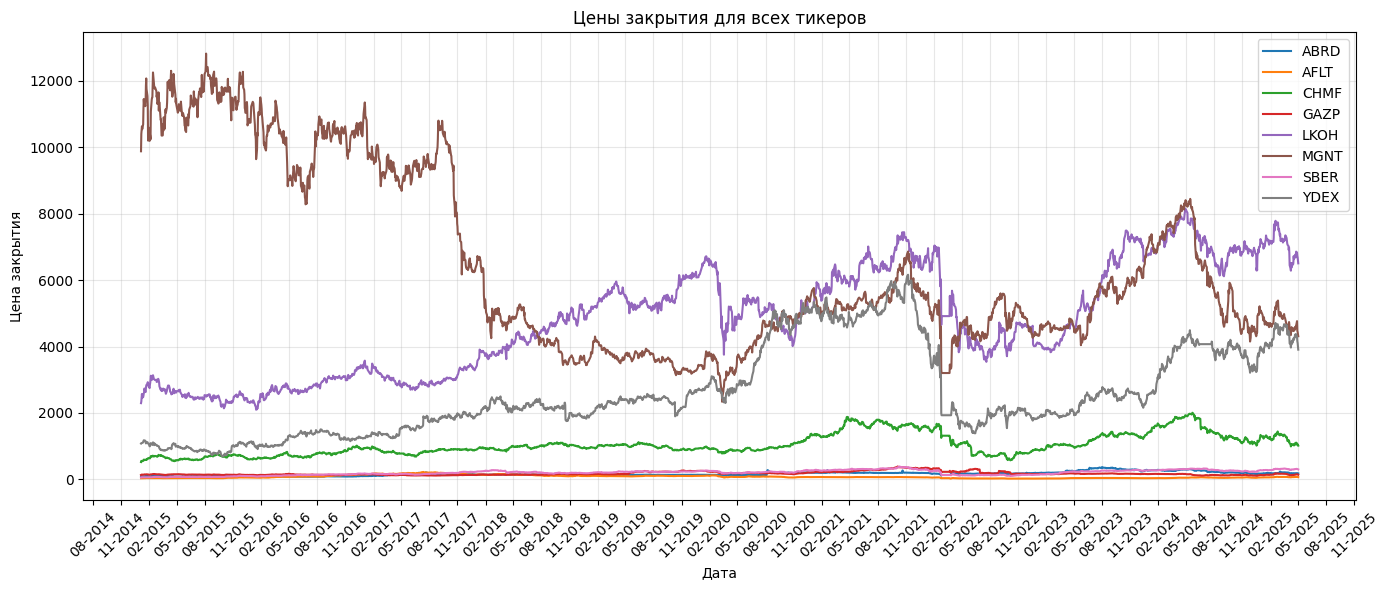

In [8]:
plot_close_prices(df=data)

## Реализация бейзлайн стратегии "Купи и держи"

Делаем бэктест стратегии "Купи и держи" на последних 10% данных каждого тикера и смотрим на перфоманс равновесного портфеля.

In [9]:
baseline_backtester = BaselineBacktest(df=data, close_price="close")

total_pf_df, total_pf_value, pf_return = baseline_backtester.buy_and_hold_performance(backtest_date=BACKTEST_DATE,
                                                                                      test_split_ratio=None,
                                                                                      init_cash=INIT_CASH)

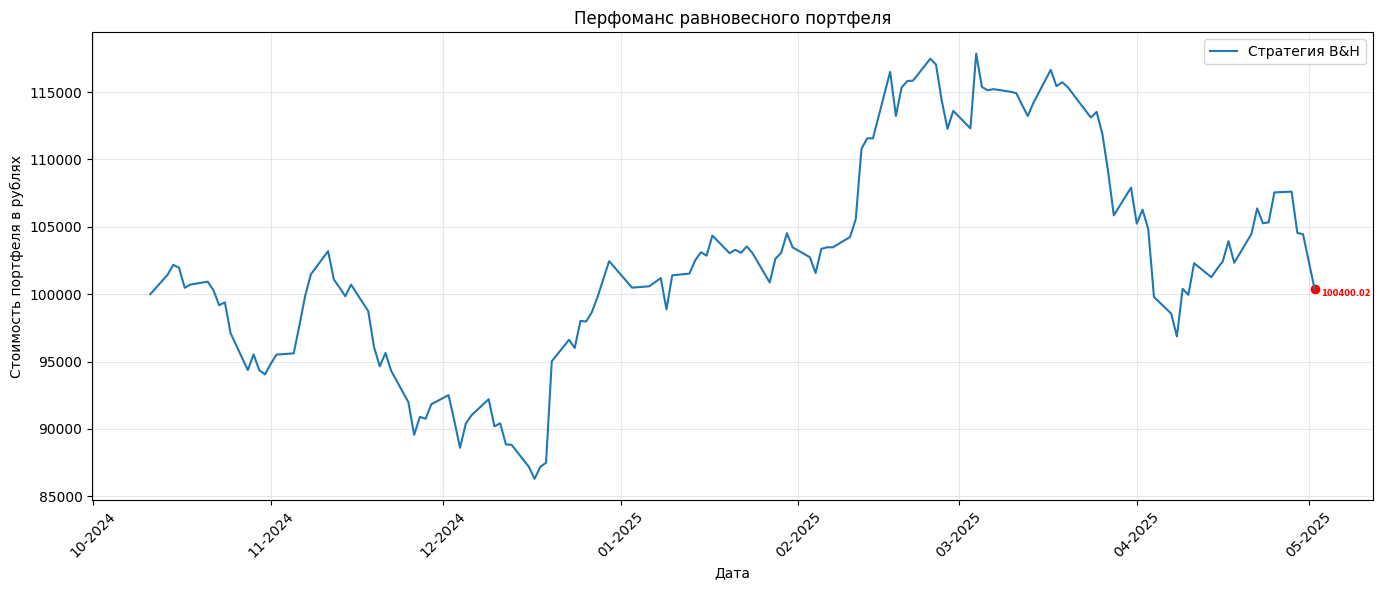

In [10]:
plot_equity(equity_series={"Стратегия B&H": total_pf_value}, 
            title="Перфоманс равновесного портфеля", 
            ylabel="Стоимость портфеля в рублях", 
            last_point=True)

In [11]:
baseline_portfolio, baseline_metrics = baseline_backtester.run_backtest(backtest_date=BACKTEST_DATE, init_cash=INIT_CASH)
baseline_metrics

{'Sharpe Ratio': 0.16645193672229192,
 'Sortino Ratio': 0.2550184139370863,
 'Max Drawdown [%]': 17.81448517839523,
 'Total Return [%]': 0.4000199999999986}

> __Вывод:__  
> Результаты стратегии «Купи и держи» показывают небольшую доходность (0.4%), значения коэффициентов Шарпа (0.17) и Сортино (0.26), а также значительную максимальную просадку (17.81%) при практически нулевой доходности. Это указывает на низкую эффективность и высокий риск такого подхода на рассматриваемом периоде.

In [12]:
assert (round(total_pf_value, 2) - round(baseline_portfolio.value(), 2)).sum() == 0.0

## Реализация стратегии на bullish и bearish сигналах

Перейдем к реализации стратегии на сигналах. Сначала сделаем небольшой Feature engineering - с помощью класса `AnomalyDetector` создадим 2 признака: "anomaly_score" и "anomaly".

In [13]:
custom_params = {
    "n_estimators": 500,
    "contamination": 0.1,
    "n_jobs": -1,
    "random_state": 42,
    }

anomaly_detector = AnomalyDetector(df=data, model_params=custom_params)
extended_df, features = anomaly_detector.generate_features()

In [14]:
df_with_anomalies = anomaly_detector.detect_anomalies(train_period_end="2024-12-31")
df_with_anomalies.tail()

,ticker,date,open,low,high,close,volume,return,amplitude,anomaly_score,anomaly
20883,YDEX,2025-04-25,4300.5,4294.0,4374.0,4371.5,759538,0.018286,0.018631,-0.100751,0
20884,YDEX,2025-04-28,4323.0,4237.0,4358.0,4283.0,847387,-0.020245,0.028558,-0.100816,0
20885,YDEX,2025-04-29,4283.0,4131.5,4316.5,4155.0,539008,-0.029886,0.044778,-0.057645,0
20886,YDEX,2025-04-30,4155.0,3993.0,4211.0,4106.0,712617,-0.011793,0.054596,-0.061389,0
20887,YDEX,2025-05-02,4108.0,3900.0,4113.0,3905.5,561535,-0.048831,0.054615,0.034430,1


Посмотрим на аномалии и убедимся, что модель действительно работает. 

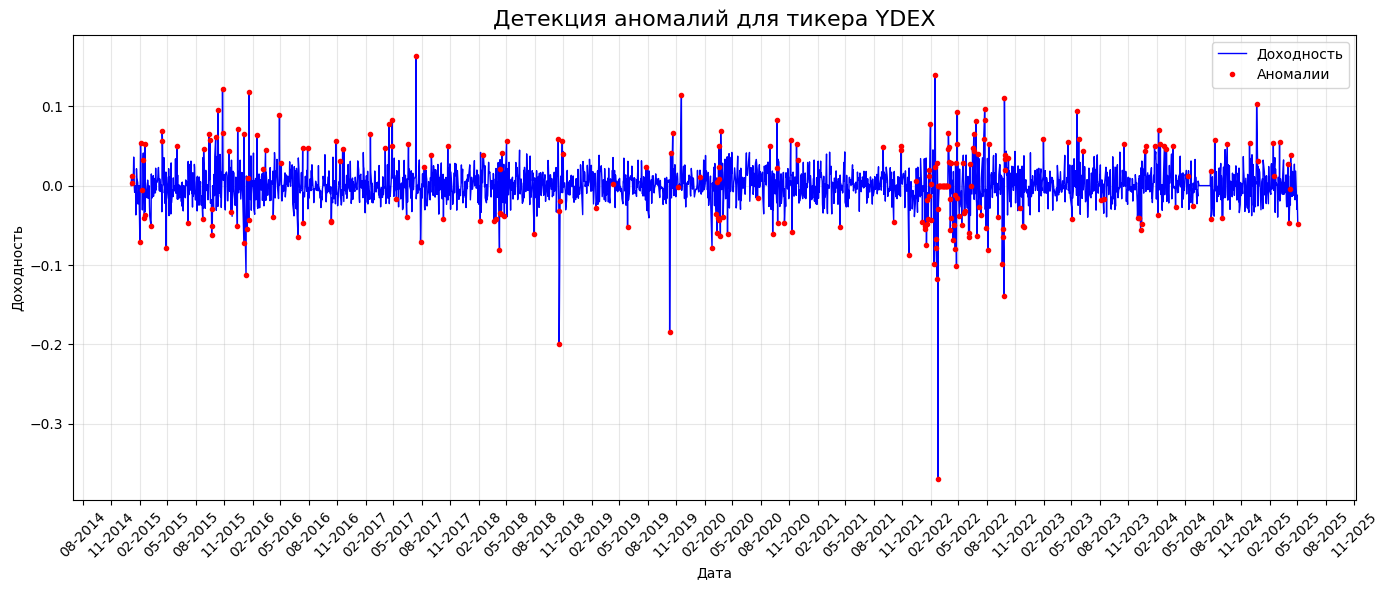

In [15]:
anomaly_detector.visualize_anomalies(ticker="YDEX", is_interactive=False)

Для того, чтобы классификатор адекватно работал, необходимо сгенерировать больше признаков, а также разметить целевую переменную (bullish и bearish сигналы).

In [16]:
gen_features = [
    "momentum_5", "momentum_10",
    "std_5", "std_10",
    "bollinger_bands_20", "bollinger_width_20",
    "atr_14", "atr_7",
    "volume_ratio_10", "volume_ratio_20", "volume_ratio_5",
    "amplitude_mean_10", "amplitude_mean_5",
    "rsi_14", "rsi_7",
    "ema_10", "ema_20", 
    "sma_10", "sma_20",
    "return_lag_10", "return_lag_20"
]

Существует несколько стратегий определения bullish/bearish сигналов:
- Стратегия на основе порогов доходности;
- Стратегия на основе пересечения скользящих средних;
- Стратегия на основе технических индикаторов;
- Стратегия на основе волатильности;
- и др.

В данной работе рассматривается __стратегия на основе волатильности__, так как она подходит для рынков с выраженной волатильностью, коим и является российский рынок в настоящее время.

__Идея__:
- Сначала вычисляется будущая доходность акций на горизонте $N$ дней (`future_return`) и текущая волатильность за последние 20 дней (`rolling_sigma`);
- На основе волатильности устанавливаются динамические пороги (+-5% от rolling_sigma) для формирования bullish, bearish, нейтрального сигналов;
- Затем формируется многоклассовый таргет: `-1 (bearish)`, `0 (нейтральный)`, `1 (bullish)`;
- Нейтральные сигналы исключаются из дальнейшего анализа, и модель CatBoost обучается только на bullish и bearish сигналах через последовательное временное разбиение данных.

In [17]:
signal_classifier = SignalClassifier(df_with_anomalies, features=gen_features, lookahead=10)

Проверим сбалансированность классов:

In [18]:
signal_classifier.check_class_balance()

Баланс классов по тикерам:
ABRD:
target
-1    1294
 1    1138
Name: count, dtype: int64

AFLT:
target
 1    1290
-1    1252
Name: count, dtype: int64

CHMF:
target
 1    1354
-1    1188
Name: count, dtype: int64

GAZP:
target
 1    1306
-1    1239
Name: count, dtype: int64

LKOH:
target
 1    1385
-1    1166
Name: count, dtype: int64

MGNT:
target
-1    1319
 1    1223
Name: count, dtype: int64

SBER:
target
 1    1446
-1    1097
Name: count, dtype: int64

YDEX:
target
 1    1364
-1    1161
Name: count, dtype: int64



In [19]:
signal_classifier.train(test_split_ratio=0.1, n_folds=5, gap=5)

proba, signals = signal_classifier.evaluate(bull_threshold=0.5, bear_threshold=0.5)

Дата разделения train/test: 2024-04-24
Оптимальное количество итераций: 51
0:	learn: 0.4473436	total: 32.4ms	remaining: 1.62s
50:	learn: 0.5483540	total: 1.19s	remaining: 0us


In [20]:
signals_piv = signals.pivot(index="date", columns="ticker", values="close")

In [21]:
signals["signal"].value_counts()

signal
 1    1696
-1     392
Name: count, dtype: int64

Посмотрим на топ-10 важных признаков:

In [22]:
feat_importance = signal_classifier.feature_importance()
feat_importance.head(10)

,Feature Id,Importances
0,atr_14,11.781203
1,ticker,9.250061
2,std_10,7.741555
3,bollinger_width_20,7.604639
4,rsi_14,7.090795
5,amplitude_mean_10,6.853692
6,rsi_7,5.866643
7,sma_10,5.152289
8,atr_7,4.832255
9,momentum_10,3.896616


In [23]:
signal_portfolio, signal_weights, signal_metrics = signal_classifier.run_backtest(signals_df=signals, backtest_date=BACKTEST_DATE, init_cash=INIT_CASH)
signal_metrics

{'Sharpe Ratio': -0.024900755161285544,
 'Sortino Ratio': -0.03790500239150582,
 'Max Drawdown [%]': 29.89690721649485,
 'Total Return [%]': -6.116010565841003}

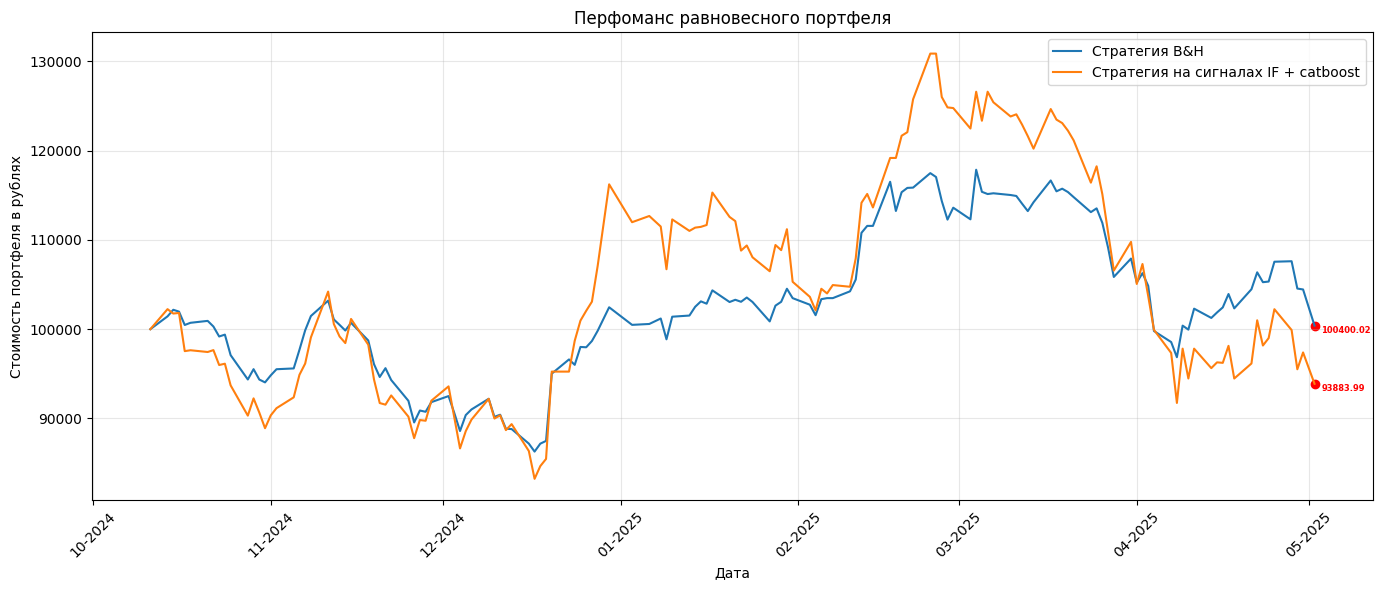

In [24]:
plot_equity(equity_series={"Стратегия B&H": total_pf_value, 
                           "Стратегия на сигналах IF + catboost" : signal_portfolio.value()}, 
            title="Перфоманс равновесного портфеля", 
            ylabel="Стоимость портфеля в рублях", 
            last_point=True)

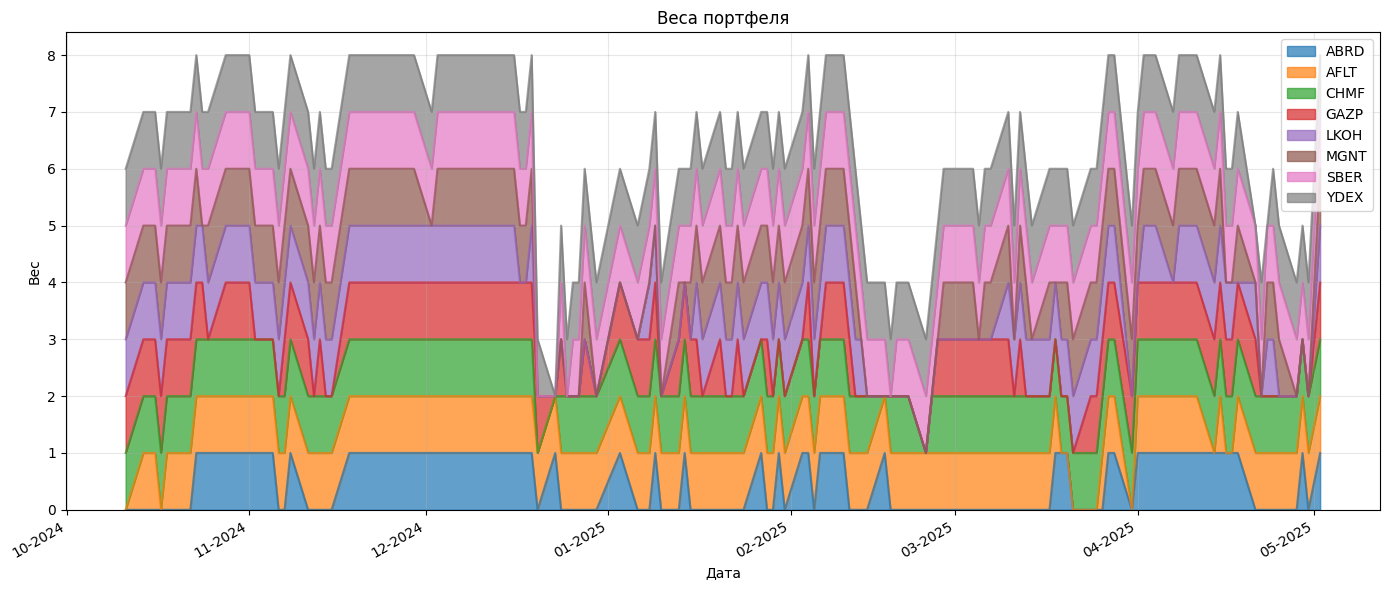

In [25]:
plot_portfolio_weights(signal_weights)

> __Вывод:__  
> Стратегия на сигналах продемонстрировала крайне низкие метрики по сравнению с бейзлайн стратегией «купи и держи». У стратегии на сигналах значительная потеря капитала (-6.12% против 0.4%), более глубокая просадка (29.90% против 17.82%) и худшие коэффициенты Шарпа и Сортино.

## CNN+LSTM модель прогнозирования доходностей

Особенность данной стратегии заключается в том, что помимо прочих признаков в LSTM необходимо передавать матрицу корреляций между тикерами, которая рассчитывается по определенному окну.
С помощью класса `FinTSDataloaders` можно подготовить dataloader'ы для LSTM, в которых создаются корреляционные матрицы и масштабируются прочие признаки.

In [26]:
loader_creator = FinTSDataloaders(df=data, window=60, forecast_horizon=7, batch_size=128)
train_loader, val_loader, test_loader, feature_scaler, target_scaler = loader_creator.get_loaders()

In [27]:
X_batch, corr_batch, y_batch = next(iter(train_loader))
feature_dim = X_batch.shape[2]
num_tickers = y_batch.shape[1]

print(f"X batch:            {X_batch.shape}")
print(f"Corr matrix batch:  {corr_batch.shape}")
print(f"y batch:            {y_batch.shape}")
print(f"Feature dim:        {feature_dim}")
print(f"Num tickers:        {num_tickers}")

X batch:            torch.Size([128, 60, 112])
Corr matrix batch:  torch.Size([128, 60, 8, 8])
y batch:            torch.Size([128, 8])
Feature dim:        112
Num tickers:        8


Для обучения, валидации и тестирования моделей глубинного обучения реализован класс `Trainer`.

In [28]:
lstm_model = LSTMForecaster(
    feature_dim=feature_dim,
    num_tickers=num_tickers
).to(DEVICE)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

lstm_trainer = Trainer(lstm_model, criterion, optimizer, scheduler, DEVICE)

In [29]:
train_losses, val_losses = lstm_trainer.train(train_loader, val_loader, epochs=100, patience=20)

Эпоха [10/100] | Train loss: 0.438373 | Val loss: 0.527534
Эпоха [20/100] | Train loss: 0.312415 | Val loss: 0.453178
Эпоха [30/100] | Train loss: 0.269796 | Val loss: 0.435738
Эпоха [40/100] | Train loss: 0.225767 | Val loss: 0.424630
Эпоха [50/100] | Train loss: 0.208097 | Val loss: 0.404074
Эпоха [60/100] | Train loss: 0.193361 | Val loss: 0.397419
Эпоха [70/100] | Train loss: 0.181537 | Val loss: 0.390305
Эпоха [80/100] | Train loss: 0.168136 | Val loss: 0.385686
Ранняя остановка на эпохе 86


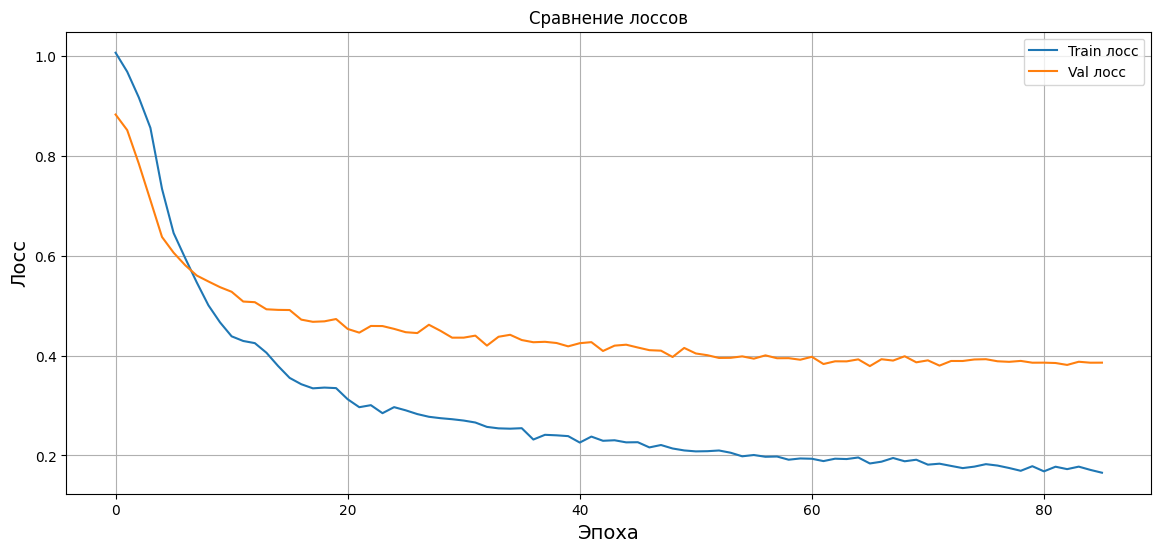

In [30]:
plot_losses(train_losses, val_losses)

In [31]:
test_loss = lstm_trainer.evaluate(test_loader)

test_preds, test_targets, lower_bounds, upper_bounds = lstm_trainer.predict(test_loader, target_scaler, train_loader, ci_coef=1)

Test loss: 0.419627


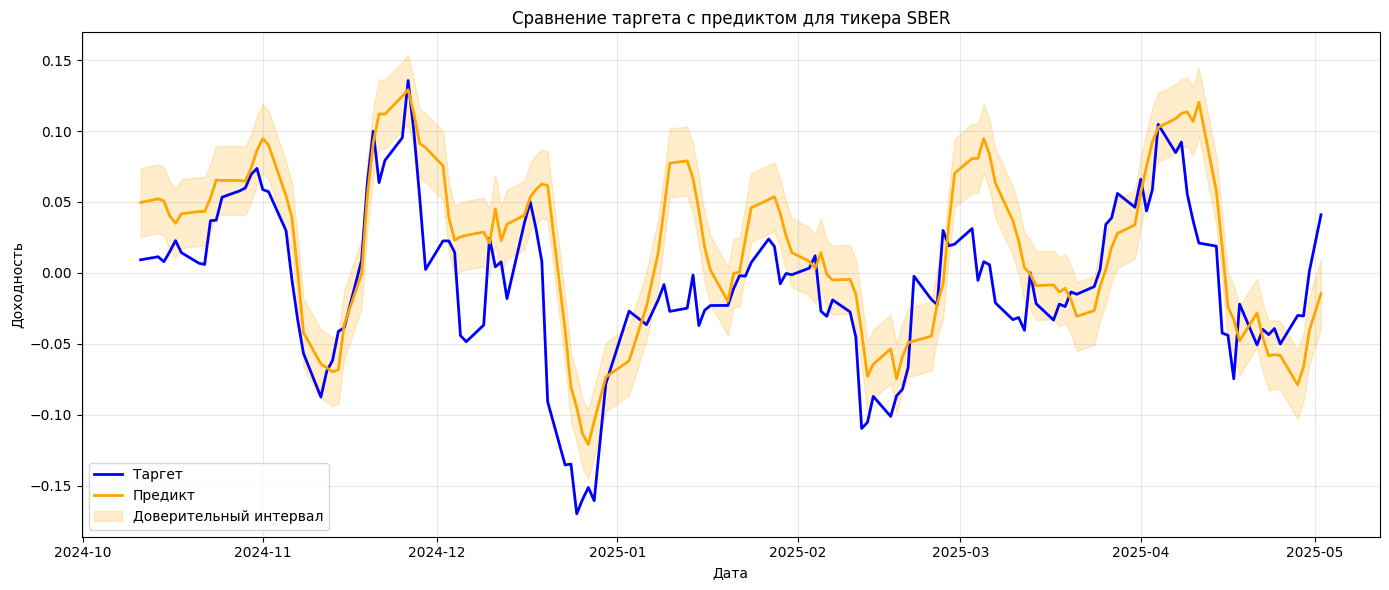

In [32]:
ticker = "SBER"

plot_lstm_predictions(df=data,
                      dataloader=test_loader,
                      ticker=ticker,
                      preds=test_preds,
                      targets=test_targets,
                      lower_bounds=lower_bounds,
                      upper_bounds=upper_bounds)

In [33]:
lstm_portfolio, lstm_weights, lstm_metrics = lstm_trainer.run_backtest(df=data, test_preds=test_preds, signal_threshold=0, init_cash=INIT_CASH)
lstm_metrics

{'Sharpe Ratio': -0.4170162422913711,
 'Sortino Ratio': -0.6356805231294765,
 'Max Drawdown [%]': 10.039867486720343,
 'Total Return [%]': -3.657017655855352}

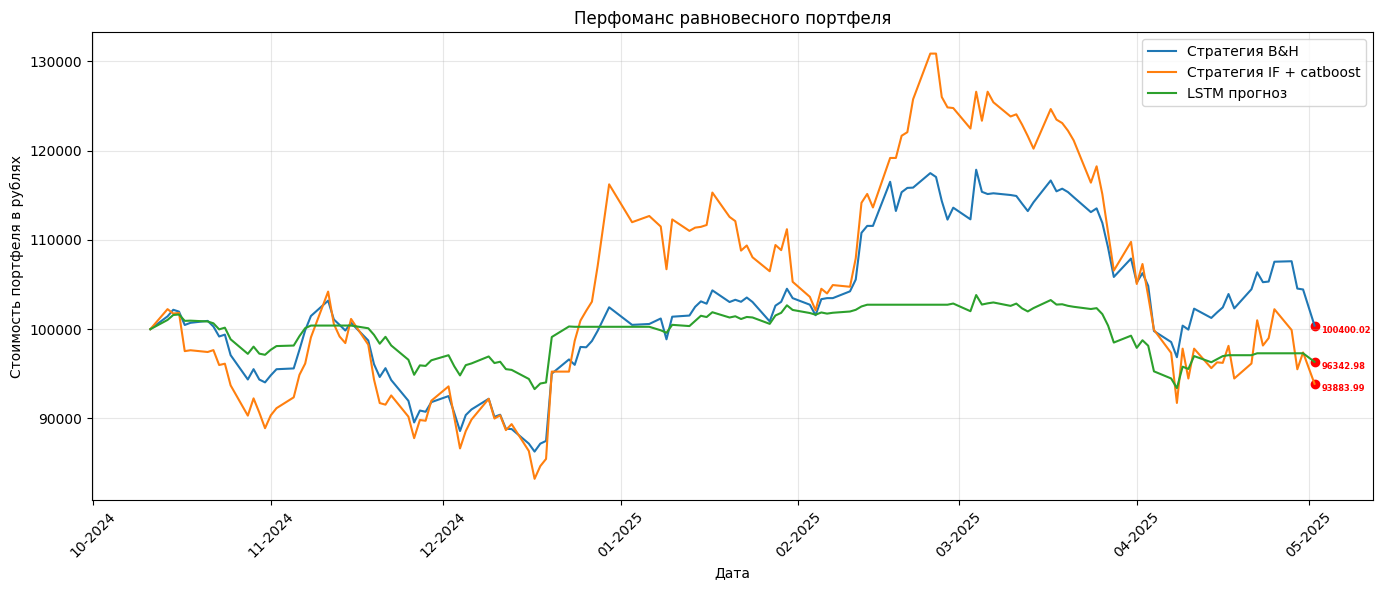

In [34]:
plot_equity(equity_series={"Стратегия B&H": total_pf_value, 
                           "Стратегия IF + catboost" : signal_portfolio.value(),
                           "LSTM прогноз" : lstm_portfolio.value()
                           }, 
            title="Перфоманс равновесного портфеля", 
            ylabel="Стоимость портфеля в рублях", 
            last_point=True)

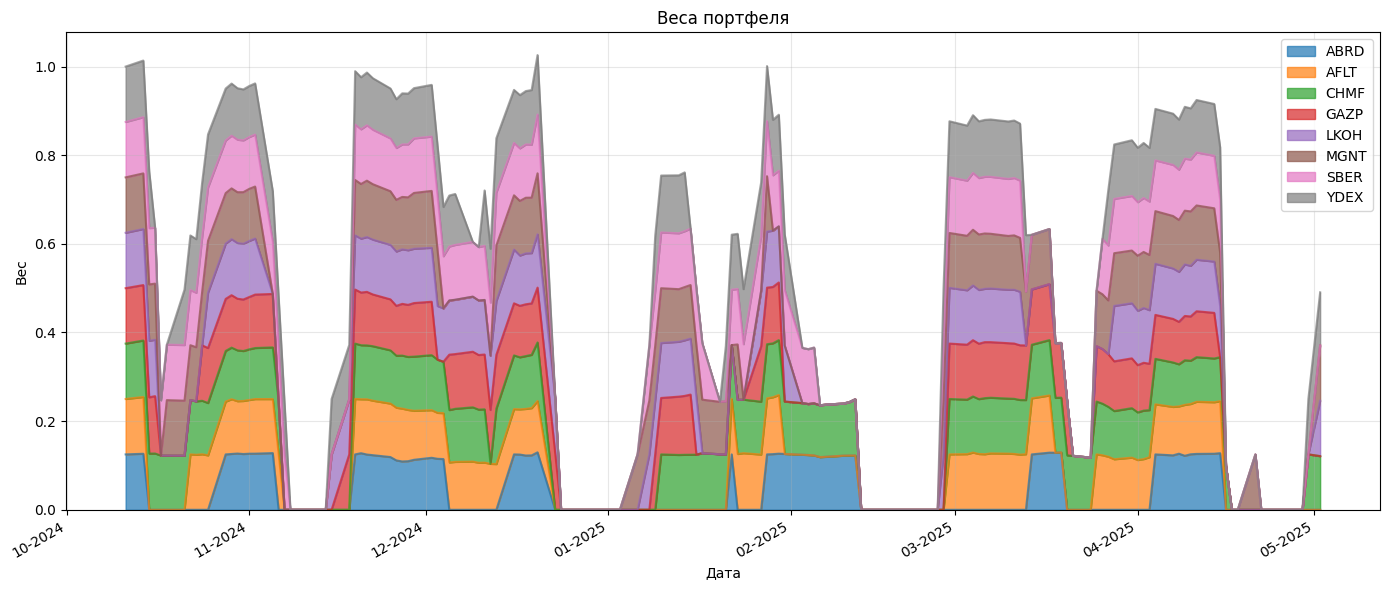

In [35]:
plot_portfolio_weights(lstm_weights)

> __Вывод:__  
> LSTM модель превосходит стратегию на сигналах, но уступает бейзлайну. Коэффициенты Шарпа и Сортино хуже, чем у других стратегий, однако максимальная просадка наилучшая - всего 10%.

## CNN+GRU модель прогнозирования доходностей

Поэксперементируем и попробуем сделать прогноз, используя GRU.

In [36]:
gru_model = GRUForecaster(
    feature_dim=feature_dim,
    num_tickers=num_tickers,
    gru_hidden=128,
    cnn_embed_dim=32
).to(DEVICE)

gru_criterion = torch.nn.MSELoss()
gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001, weight_decay=0.001)
gru_scheduler = ReduceLROnPlateau(gru_optimizer, patience=20, factor=0.5)

gru_trainer = Trainer(gru_model, gru_criterion, gru_optimizer, gru_scheduler, DEVICE)

train_losses, val_losses = gru_trainer.train(train_loader, val_loader, epochs=100, patience=100)

Эпоха [10/100] | Train loss: 0.261040 | Val loss: 0.308571
Эпоха [20/100] | Train loss: 0.232558 | Val loss: 0.281498
Эпоха [30/100] | Train loss: 0.211473 | Val loss: 0.273139
Эпоха [40/100] | Train loss: 0.199463 | Val loss: 0.277613
Эпоха [50/100] | Train loss: 0.187587 | Val loss: 0.275470
Эпоха [60/100] | Train loss: 0.173004 | Val loss: 0.258612
Эпоха [70/100] | Train loss: 0.183957 | Val loss: 0.278309
Эпоха [80/100] | Train loss: 0.173396 | Val loss: 0.251440
Эпоха [90/100] | Train loss: 0.172391 | Val loss: 0.255466


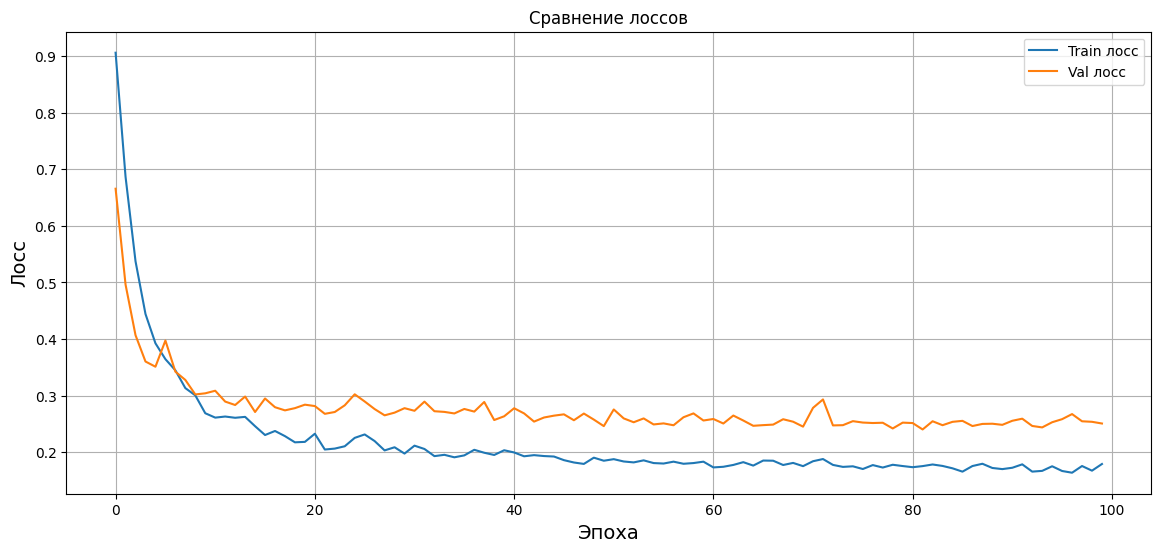

In [37]:
plot_losses(train_losses, val_losses)

In [38]:
test_loss = gru_trainer.evaluate(test_loader)

test_preds, test_targets, lower_bounds, upper_bounds = gru_trainer.predict(test_loader, target_scaler, train_loader, ci_coef=1)

Test loss: 0.273598


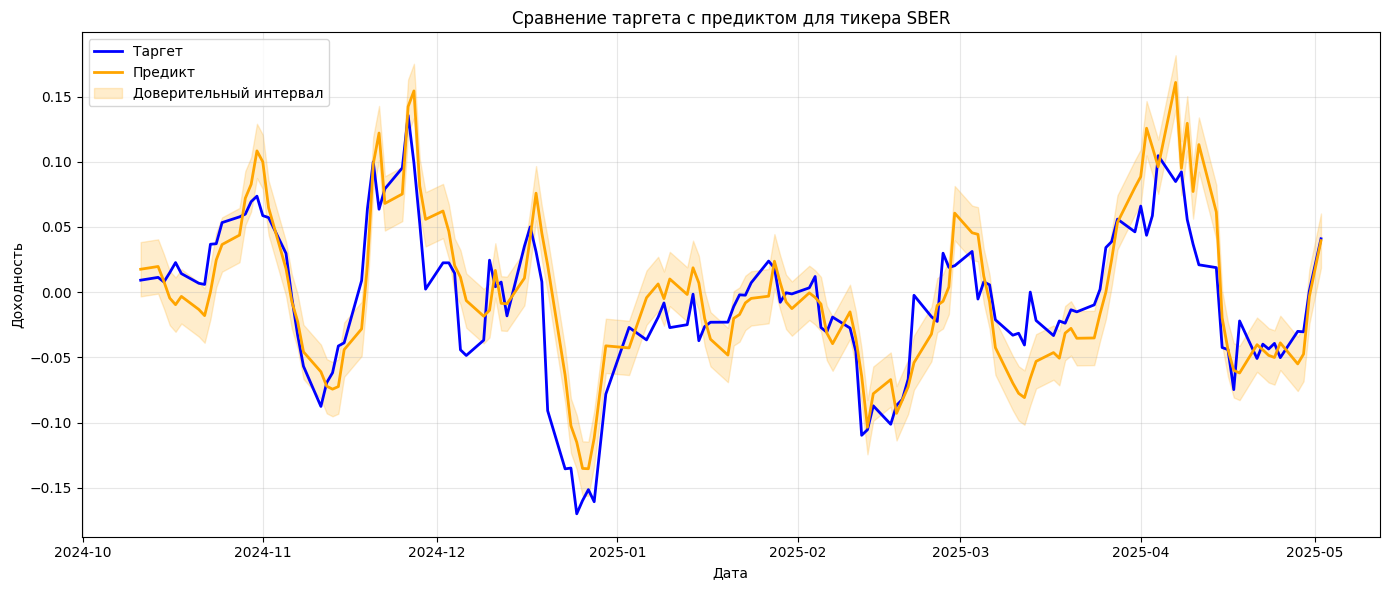

In [39]:
ticker = "SBER"

plot_lstm_predictions(df=data,
                      dataloader=test_loader,
                      ticker=ticker,
                      preds=test_preds,
                      targets=test_targets,
                      lower_bounds=lower_bounds,
                      upper_bounds=upper_bounds)

In [40]:
gru_portfolio, gru_weights, gru_metrics = gru_trainer.run_backtest(df=data, test_preds=test_preds, signal_threshold=0, init_cash=INIT_CASH)
gru_metrics

{'Sharpe Ratio': -0.33504062046122884,
 'Sortino Ratio': -0.5078542768874517,
 'Max Drawdown [%]': 10.083459310304827,
 'Total Return [%]': -3.211614950235063}

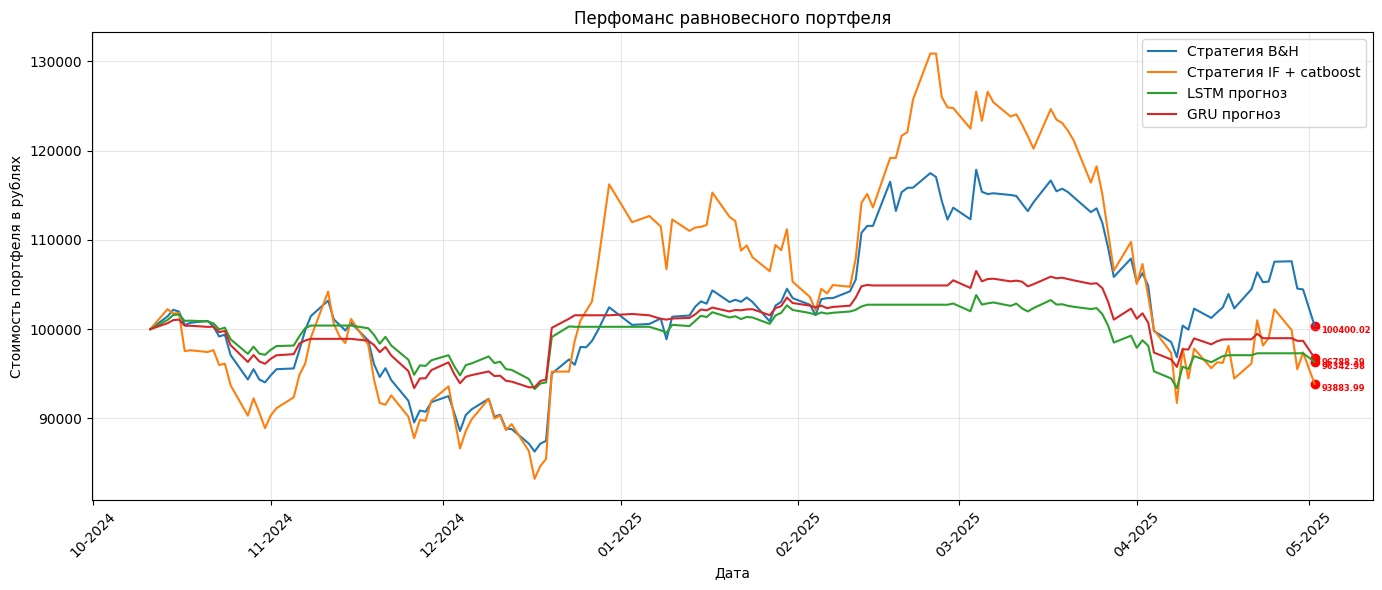

In [41]:
plot_equity(equity_series={"Стратегия B&H": total_pf_value, 
                           "Стратегия IF + catboost" : signal_portfolio.value(),
                           "LSTM прогноз" : lstm_portfolio.value(),
                           "GRU прогноз" : gru_portfolio.value()
                           }, 
            title="Перфоманс равновесного портфеля", 
            ylabel="Стоимость портфеля в рублях", 
            last_point=True)

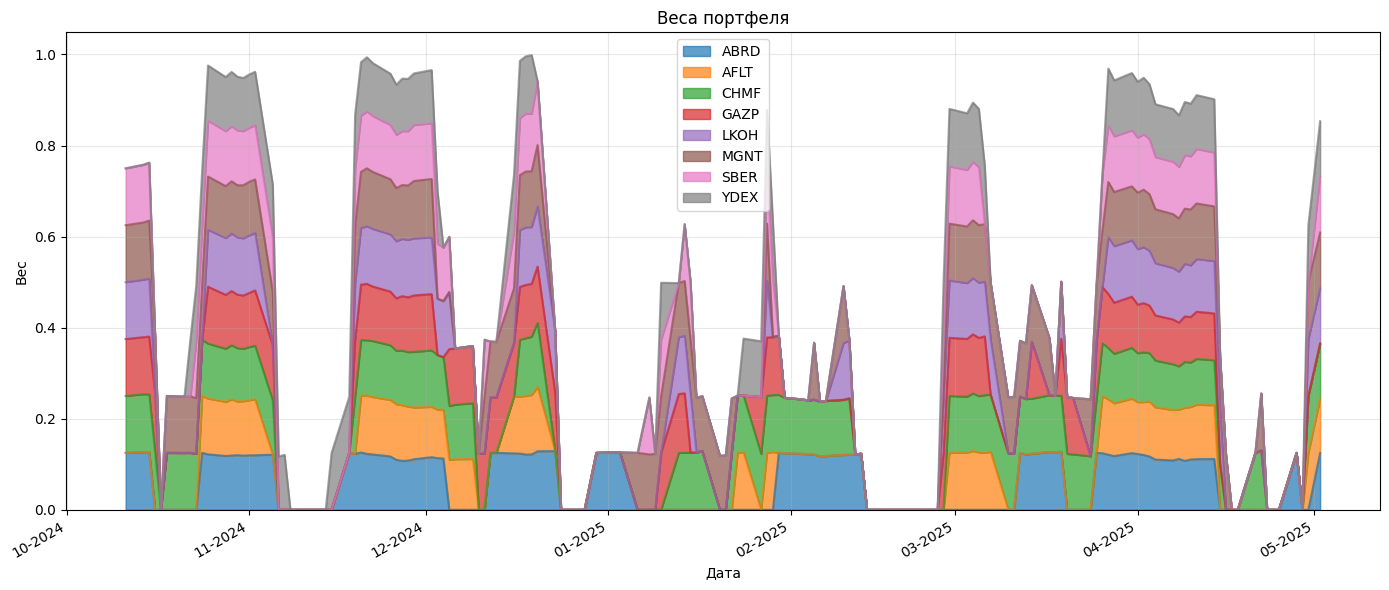

In [42]:
plot_portfolio_weights(gru_weights)

> __Вывод:__  
> GRU модель оказалась немного лучше, чем LSTM. Коэффициенты Шарпа и Сортино выше, хотя все еще отрицательные. Доходность лучше, но также отрицательная.

## CNN+LSTM+Attention модель прогнозирования доходностей

Теперь попробуем добавить механизм внимания к LSTM и посмотрим, что из этого выйдет.

In [43]:
attention_model = AttentionLSTMForecaster(
    feature_dim=feature_dim,
    num_tickers=num_tickers,
    lstm_hidden=128,
    cnn_embed_dim=32,
    attention_heads=32
).to(DEVICE)

att_criterion = torch.nn.MSELoss()
att_optimizer = torch.optim.Adam(attention_model.parameters(), lr=0.001, weight_decay=0.001)
att_scheduler = ReduceLROnPlateau(att_optimizer, patience=20, factor=0.5)

att_trainer = Trainer(attention_model, att_criterion, att_optimizer, att_scheduler, DEVICE)

train_losses, val_losses = att_trainer.train(train_loader, val_loader, epochs=100, patience=100)

Эпоха [10/100] | Train loss: 0.324841 | Val loss: 0.391997
Эпоха [20/100] | Train loss: 0.257701 | Val loss: 0.369244
Эпоха [30/100] | Train loss: 0.259163 | Val loss: 0.345500
Эпоха [40/100] | Train loss: 0.251633 | Val loss: 0.345052
Эпоха [50/100] | Train loss: 0.247431 | Val loss: 0.347026
Эпоха [60/100] | Train loss: 0.241553 | Val loss: 0.385664
Эпоха [70/100] | Train loss: 0.231093 | Val loss: 0.343697
Эпоха [80/100] | Train loss: 0.231426 | Val loss: 0.341088
Эпоха [90/100] | Train loss: 0.224841 | Val loss: 0.341468


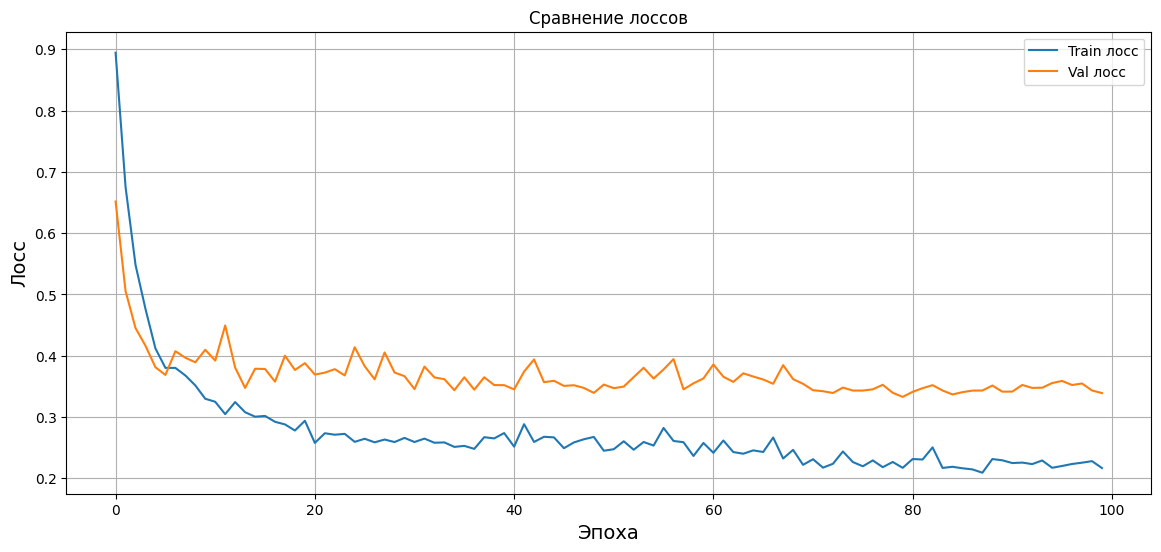

In [44]:
plot_losses(train_losses, val_losses)

In [45]:
test_loss = att_trainer.evaluate(test_loader)

test_preds, test_targets, lower_bounds, upper_bounds = att_trainer.predict(test_loader, target_scaler, train_loader, ci_coef=1)

Test loss: 0.294116


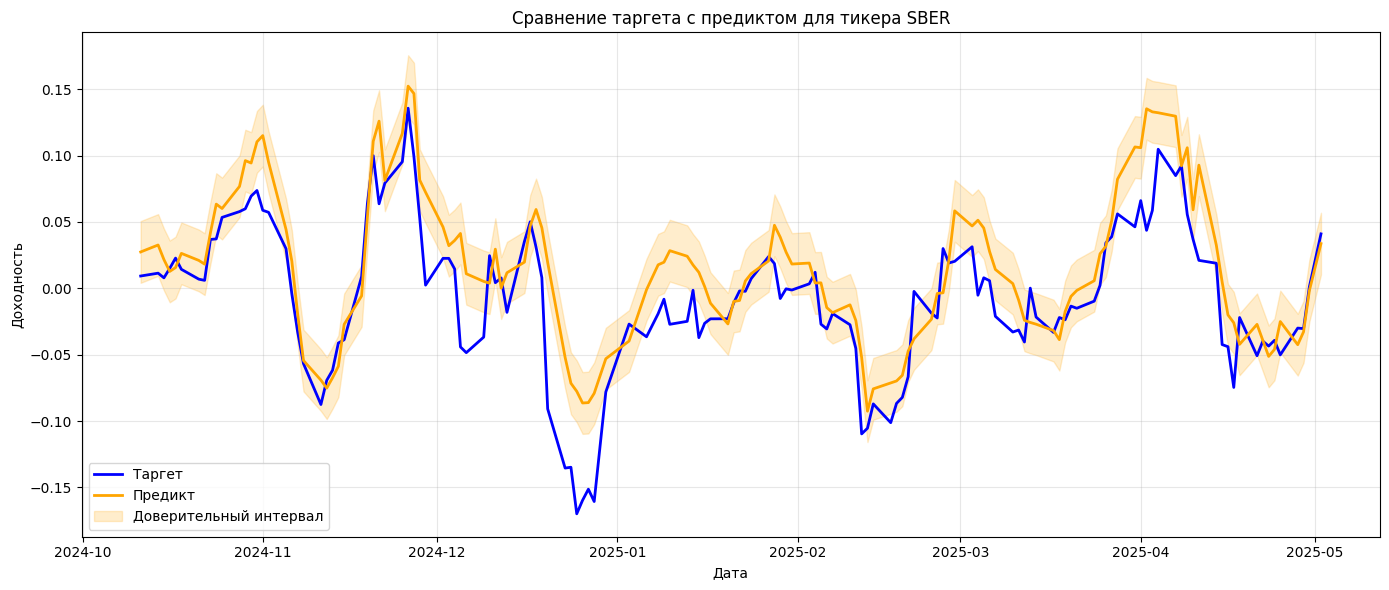

In [46]:
ticker = "SBER"

plot_lstm_predictions(df=data,
                      dataloader=test_loader,
                      ticker=ticker,
                      preds=test_preds,
                      targets=test_targets,
                      lower_bounds=lower_bounds,
                      upper_bounds=upper_bounds)

In [47]:
att_portfolio, att_weights, att_metrics = att_trainer.run_backtest(df=data, test_preds=test_preds, signal_threshold=0, init_cash=INIT_CASH)
att_metrics

{'Sharpe Ratio': -0.7389483246039679,
 'Sortino Ratio': -1.0715075025565266,
 'Max Drawdown [%]': 11.546529316980608,
 'Total Return [%]': -6.273459373081154}

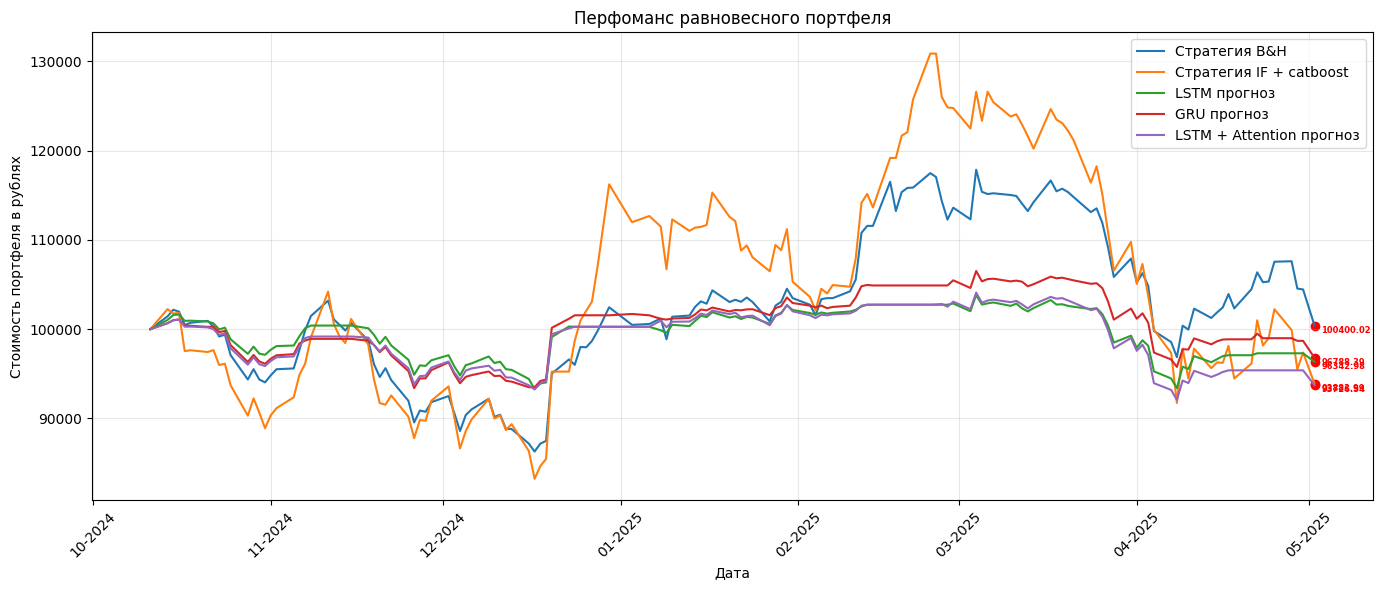

In [48]:
plot_equity(equity_series={"Стратегия B&H": total_pf_value, 
                           "Стратегия IF + catboost" : signal_portfolio.value(),
                           "LSTM прогноз" : lstm_portfolio.value(),
                           "GRU прогноз" : gru_portfolio.value(),
                           "LSTM + Attention прогноз" : att_portfolio.value()
                           },
            title="Перфоманс равновесного портфеля", 
            ylabel="Стоимость портфеля в рублях", 
            last_point=True)

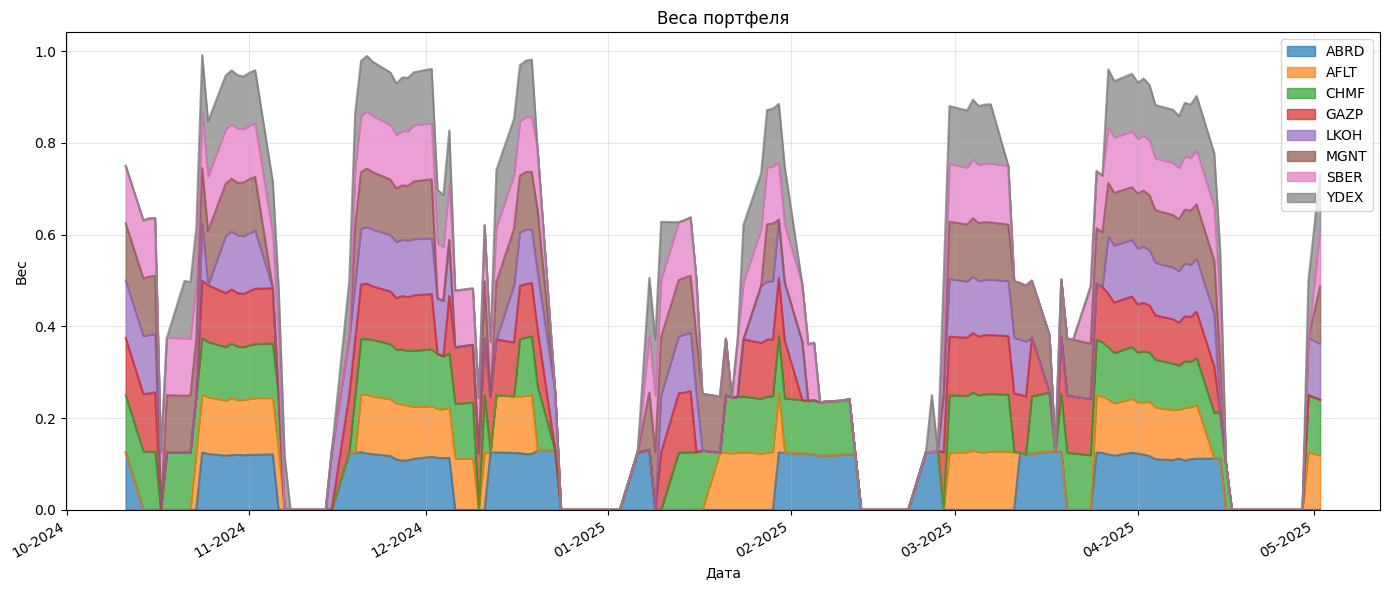

In [49]:
plot_portfolio_weights(att_weights)